In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("regression_lab")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='regression_lab', tags={}>

In [3]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


In [8]:
csv_url = ("db/data.csv")
data = pd.read_csv(csv_url)
data = data.drop(columns=['Unnamed: 0'])


In [9]:
train, test = train_test_split(data)

train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]


In [10]:
alpha = 0.5
l1_ratio = 0.5
selection = "random"

In [11]:
with mlflow.start_run():
    mlflow.set_tag("modele", "ElasticNet")
    mlflow.set_tag("status", "baseline")
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_param("selection", selection)
    
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio,random_state=42,selection=selection)
    lr.fit(train_x, train_y)
    
    predicted_qualities = lr.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticnetWineModel")
#     mlflow.log_artifact(local_path="models/lr_reg.bin", artifact_path="models_pickle")


Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 0.7875128179179958
  MAE: 0.6153233463302683
  R2: 0.11014850425856859


Successfully registered model 'ElasticnetWineModel'.
2022/09/16 16:30:19 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ElasticnetWineModel, version 1
Created version '1' of model 'ElasticnetWineModel'.


C:\Users\Eloua\AppData\Local\Temp\ipykernel_10108\1333049571.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predicted_qualities, label='prediction')
C:\Users\Eloua\AppData\Local\Temp\ipykernel_10108\1333049571.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_y, label='actual')


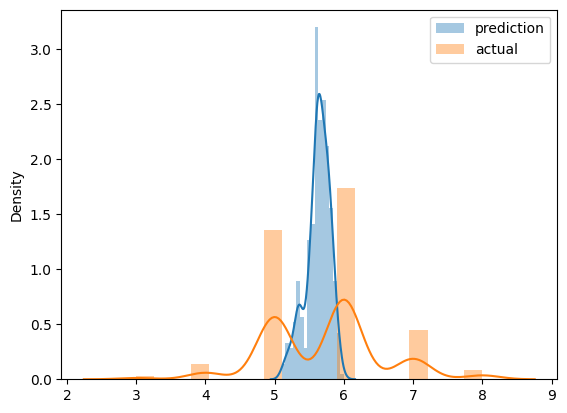

In [16]:
sns.distplot(predicted_qualities, label='prediction')
sns.distplot(test_y, label='actual')

plt.legend()

In [18]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [31]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("modele", "ElasticNet")
        mlflow.set_tag("status", "hyperparameter-tuning")
        mlflow.log_params(params)
        lr = ElasticNet(**params)
        lr.fit(train_x, train_y)
        predicted_qualities = lr.predict(test_x)
        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
    return {'loss': rmse, 'status': STATUS_OK}

In [36]:
search_space = {
    'alpha': hp.uniform('alpha', 0, 0.01),
    'l1_ratio': hp.uniform('l1_ratio', 0, 0.6),
    'tol':hp.loguniform('tol', -10, -6),
    'selection': 'random',
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

100%|██████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.93trial/s, best loss: 0.6558610562834335]


In [27]:
search_space = {
    'alpha': hp.uniform('alpha', -2, 2),
    'l1_ratio': hp.uniform('l1_ratio', -2, 2),
}

In [25]:
search_space

{'max_depth': <hyperopt.pyll.base.Apply at 0x28d52284b20>,
 'learning_rate': <hyperopt.pyll.base.Apply at 0x28d52294430>}